<h1><span style="color: #5D3FD3;"> Objective 1b: Image Classifier using CNN</span></h1>

<br>

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Muhammad Fitri Amir bin Abdullah|DAAA/FT/2B/06|2222811|

In this task, instead of importing pictures as 128x128, we shall change the image size to 31x31. The same rules and regularisations apply:
- change pictures to grayscale (3 channels -> 1)
- use the same photos that are given in the dataset
- Use initial baseline model results to find model improvements and test them out
- Set initial theory and implement some features to help the model, which are most likely different from bigger images.
<hr>

## <span style="color: #5D3FD3;"> 1) Data Preparation </span>

### 1a) Importing data

In [8]:
import wandb
wandb.init(project="cnn-part-b")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fenriyx (sp-work). Use `wandb login --relogin` to force relogin


In [9]:
import numpy as np
import pandas as pd
import datetime
import os, time, math, datetime, warnings, pytz, glob, PIL
import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import plotly as px
import plotly.graph_objects as go
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model
from functools import reduce, wraps
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

from wandb.keras import WandbCallback

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, SGD

custom  = {"axes.edgecolor" : "white", 
            "grid.linestyle": "dashed",
            "grid.color": "gray"
            }
sns.set_style("whitegrid", rc = custom)

### 1b) Utility functions

In [2]:
def read_pic(dataset_path, filename):
    images = []
    labels = []
    folder_path = os.path.join(dataset_path, filename)
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (31, 31))
            image = image.astype('float32')
            images.append(image)
            labels.append(label)
    #         images = np.array(images)
    #         labels = np.array(labels)
    return images, labels

In [13]:
def print_training_history(history):
    # Print training and validation losses
    print("Training Loss:", history.history['loss'][-1])
    print("Validation Loss:", history.history['val_loss'][-1])

    # Print training and validation accuracies
    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])

In [15]:
def plot_lc(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Cross Entropy Loss', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend()

    ax[1].plot(acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
def preprocess(train, test, val):

    # unpack data
    X_train, y_train = train
    X_test, y_test = test
    X_val, y_val = val

    # normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    X_val = X_val / 255.0

    # Reshape the data (assuming 31x31 images)
    input_shape = (31, 31, 1)  # Adjust based on your image size and channels
    X_train = X_train.reshape(X_train.shape[0], *input_shape)
    X_test = X_test.reshape(X_test.shape[0], *input_shape)
    X_val = X_val.reshape(X_val.shape[0], *input_shape)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.transform(y_val)

    # one hot encode labels
    y_train = to_categorical(y_train, num_classes = len(np.unique(y_train)))
    y_test = to_categorical(y_test, num_classes= len(np.unique(y_test)))
    y_val = to_categorical(y_val, num_classes= len(np.unique(y_val)))

    return (X_train, y_train), (X_test, y_test), (X_val, y_val)

### 1c) Loading and checking data

In [6]:
dataset_path = "Datasets/Dataset for CA1 part A/"

# Load training images and labels
train_images, train_labels = read_pic(dataset_path, "train")
X_train = np.array(train_images)
y_train = np.array(train_labels)

# Load test images and labels
test_images, test_labels = read_pic(dataset_path, "test")
X_test = np.array(test_images)
y_test = np.array(test_labels)

val_images, val_labels = read_pic(dataset_path, "validation")
X_val = np.array(val_images)
y_val = np.array(val_labels)

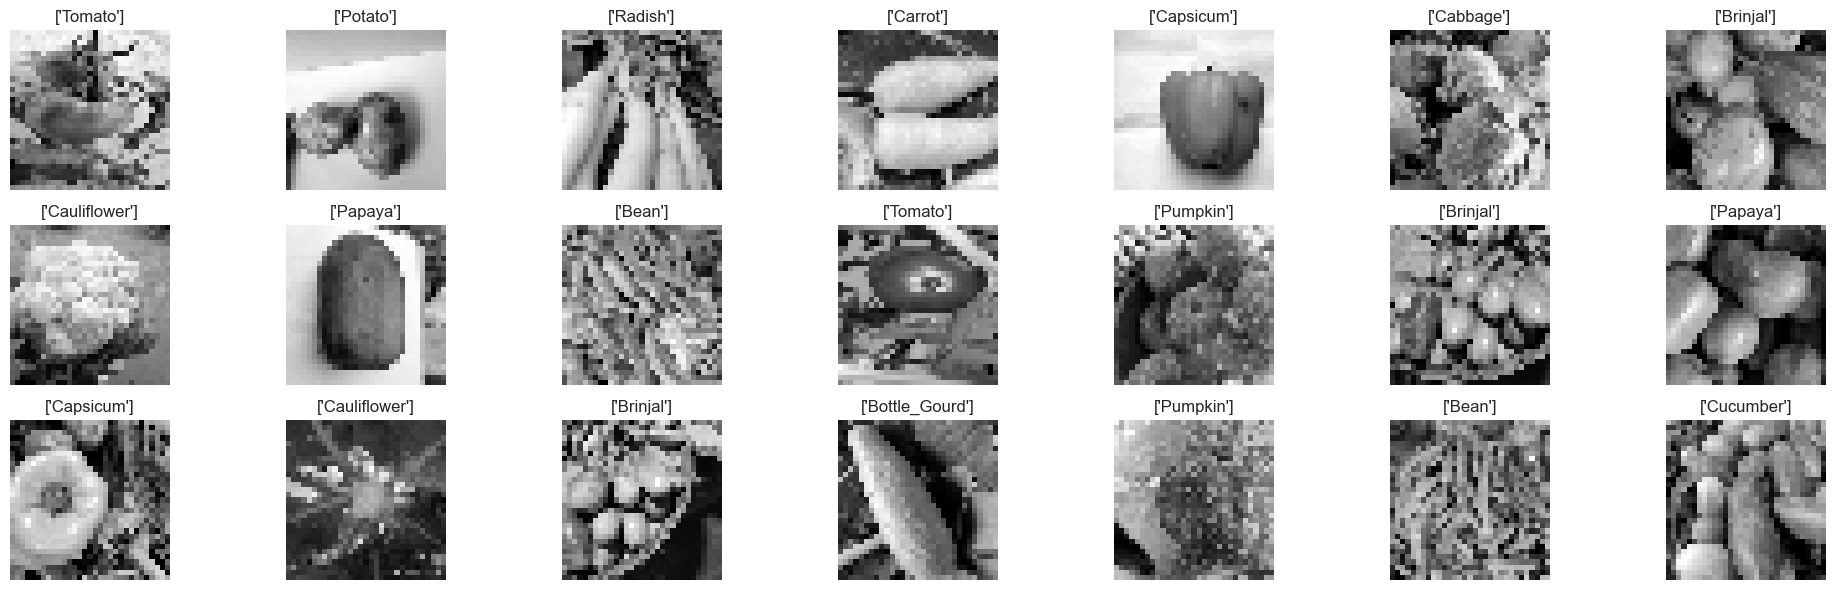

In [5]:
fig = plt.figure(figsize=(20, 6))
for i in range(1, 22):
    randn = int(np.random.random() * len(X_train))
    ax = fig.add_subplot(3, 7, i)
    ax.imshow(X_train[randn], cmap='gray')  # Use cmap='gray' to display grayscale images
    ax.set_title([y_train.flatten()[randn]])
    ax.axis('off')

plt.tight_layout()
plt.show()

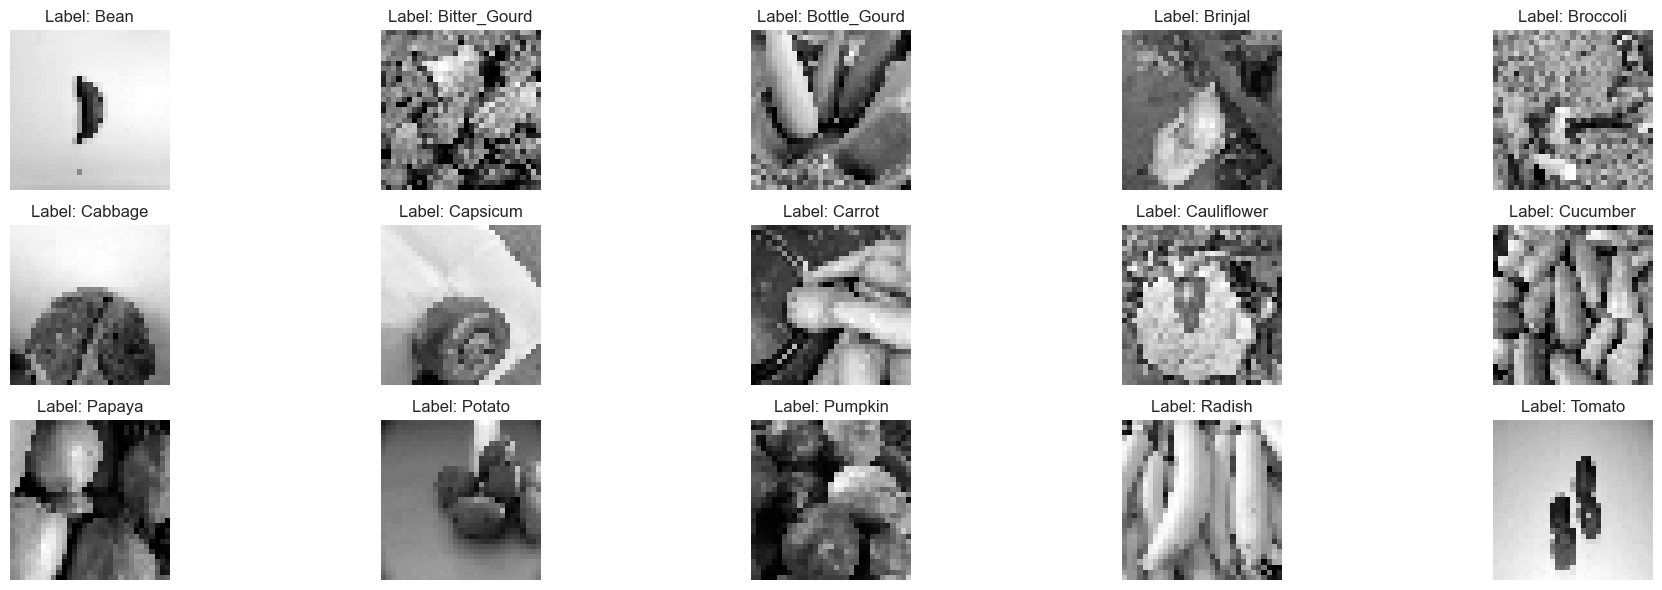

In [6]:
fig = plt.figure(figsize=(20, 6))

for i, label in enumerate(np.unique(y_train), start=1):
    # Find the index of the first image with the current label
    index = np.where(y_train == label)[0][0]
    
    # Add a subplot for each label
    ax = fig.add_subplot(3, 5, i)  
    
    # Display the image
    ax.imshow(X_train[index], cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


As we can see, the images imported are blurry. This is most likely because the pictures have been compressed a lot more as compared to 128x128. These are some things we need to note that will be different than 128x128: 
Under Section 3 from this paper: <a href = "https://arxiv.org/pdf/2102.01582.pdf#:~:text=Has%20the%20size%20of%20the,classification%20accuracy%20(Section%203.1)."> this paper </a> we can see that these are the results of different CNN model architectures that were trained on the same dataset, but 2 different resolutions: 

<center>

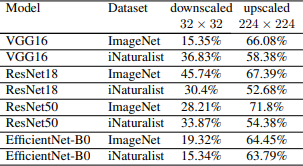

</center>

- Smaller images tend to cause a loss of information
- I will not do data augmentation first as I feel that the images capture the features of the different vegetables well.
- A model trained on one resolution may not generalize well to another resolution.
- Lower resolution images may allow for faster training and inference times.
- At the same time, with less clear features, the model may be able to pick up more distinct patterns that may be available in different vegetables, and hence may improve.
- As mentioned in the 128x128 file, where we needed to capture more features through implmenting more layers, we may be able to apply less layers as the model might need lesser features.

In [7]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = preprocess((X_train, y_train), (X_test, y_test), (X_val, y_val))

In [10]:
input_shape = (31, 31, 1)
 
# Create a sequential model
model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128))

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])

model.save("baselineModel31.h5")
model.summary()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
280/283 [============================>.] - ETA: 0s - loss: 2.0716 - accuracy: 0.3562

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 13s 12ms/step - loss: 2.0675 - accuracy: 0.3578 - val_loss: 1.7529 - val_accuracy: 0.4690
Epoch 2/100
278/283 [============================>.] - ETA: 0s - loss: 1.4309 - accuracy: 0.5640

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 3s 11ms/step - loss: 1.4297 - accuracy: 0.5641 - val_loss: 1.4680 - val_accuracy: 0.5563
Epoch 3/100
273/283 [===========================>..] - ETA: 0s - loss: 1.1242 - accuracy: 0.6624

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 3s 12ms/step - loss: 1.1254 - accuracy: 0.6619 - val_loss: 1.3984 - val_accuracy: 0.5733
Epoch 4/100
281/283 [============================>.] - ETA: 0s - loss: 0.9080 - accuracy: 0.7303

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 3s 10ms/step - loss: 0.9091 - accuracy: 0.7300 - val_loss: 1.3256 - val_accuracy: 0.6000
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 0.7453 - accuracy: 0.7796 - val_loss: 1.3543 - val_accuracy: 0.5833
Epoch 6/100
271/283 [===========================>..] - ETA: 0s - loss: 0.5963 - accuracy: 0.8239

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 2s 9ms/step - loss: 0.5954 - accuracy: 0.8243 - val_loss: 1.1897 - val_accuracy: 0.6517
Epoch 7/100
283/283 [==============================] - 3s 11ms/step - loss: 0.4938 - accuracy: 0.8563 - val_loss: 1.2667 - val_accuracy: 0.6370
Epoch 8/100
283/283 [==============================] - 5s 17ms/step - loss: 0.4108 - accuracy: 0.8811 - val_loss: 1.2034 - val_accuracy: 0.6690
Epoch 9/100
283/283 [==============================] - 5s 17ms/step - loss: 0.3254 - accuracy: 0.9067 - val_loss: 1.2119 - val_accuracy: 0.6617
Epoch 10/100
283/283 [==============================] - 4s 16ms/step - loss: 0.2718 - accuracy: 0.9284 - val_loss: 1.2160 - val_accuracy: 0.6760
Epoch 11/100
283/283 [==============================] - 4s 16ms/step - loss: 0.2269 - accuracy: 0.9374 - val_loss: 1.3238 - val_accuracy: 0.6680
Epoch 12/100
283/283 [==============================] - 4s 14ms/step - loss: 0.2030 - accuracy: 0.9434 - val_loss: 1.2888 - val_accuracy: 0.6877
Ep

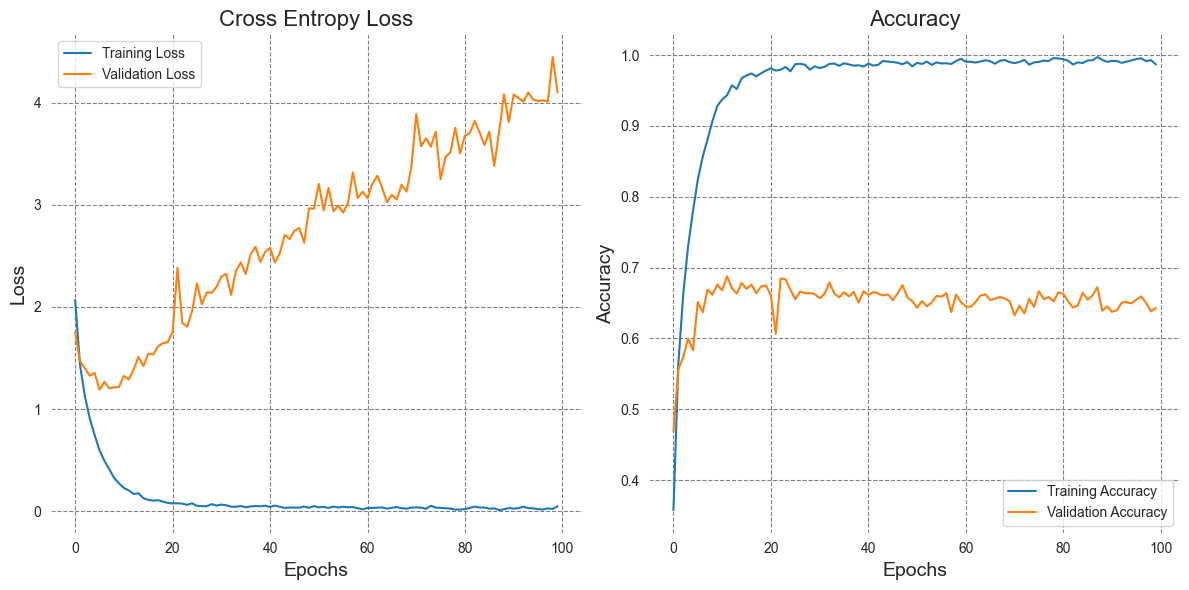

In [16]:
plot_lc(history)

In [14]:
print_training_history(history)

Training Loss: 0.049123406410217285
Validation Loss: 4.100975513458252
Training Accuracy: 0.9869295358657837
Validation Accuracy: 0.6430000066757202


As we can see, the model is overfitting. The validation loss is increasing to 4.1, while the training loss is sticking to as low as 0.05 loss from the 20th epoch all the way to the 100th. The accuracy tells us a similar story, where the training accuracy is reaching up to 98%, but the validation accuracy is stuck at 64%. Compared to our 128x128 model, we can see that this model is a lot more stable with lesser anomalies in terms of accuracy and loss, but the validation loss still has some anomalies such as the one at the 70th epoch. Therefore, the main problem is overfitting, which has a lot of solutions, mainly:

> Data augmentation <br>

Helps us to crop the photos such that the model is able to get different orientations of the same picture, helping it to recognise more features and taxes the training accuracy.<br>

> L1/L2/Elastic net regularisation<br>

Sets a penalty, either the sum of absolute value of weights(L1), which means that it shrinks the weightage of less important features to 0, or taking the sum of square of weights, which allows the model to keep the less important features, but has a better sense of generalisation.<br>

> Adding a layer to allow more complex patterns<br>

Similar to 128x128, it may not be able to memorise certain complex patterns using just one layer. By allowing the model to be more complex, it allows the model to classify the vegetables better.<br>


I will be trying L2 as the model should take in most of the features because there are not a lot of pictures, hence more data would be needed to classify what type of vegetable it is.

In [40]:
model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer = l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Dont use data augmentation(datagen.flow)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])
model.summary()
model.save("l2Model31.h5")

Epoch 1/100
  1/283 [..............................] - ETA: 1:46 - loss: 5.2554 - accuracy: 0.0938WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_train_batch_end` time: 0.0066s). Check your callbacks.


283/283 [==============================] - 3s 10ms/step - loss: 2.7672 - accuracy: 0.1638 - val_loss: 2.6354 - val_accuracy: 0.1800
Epoch 2/100
283/283 [==============================] - 3s 9ms/step - loss: 2.4580 - accuracy: 0.2425 - val_loss: 2.4865 - val_accuracy: 0.2633
Epoch 3/100
283/283 [==============================] - 3s 10ms/step - loss: 2.3612 - accuracy: 0.2788 - val_loss: 2.3787 - val_accuracy: 0.2693
Epoch 4/100
283/283 [==============================] - 3s 9ms/step - loss: 2.3001 - accuracy: 0.3125 - val_loss: 2.3098 - val_accuracy: 0.3333
Epoch 5/100
283/283 [==============================] - 3s 9ms/step - loss: 2.2383 - accuracy: 0.3334 - val_loss: 2.2130 - val_accuracy: 0.3560
Epoch 6/100
283/283 [==============================] - 3s 9ms/step - loss: 2.2036 - accuracy: 0.3470 - val_loss: 2.2051 - val_accuracy: 0.3413
Epoch 7/100
283/283 [==============================] - 3s 9ms/step - loss: 2.1654 - accuracy: 0.3597 - val_loss: 2.1222 - val_accuracy: 0.4110
Epoch 8/1

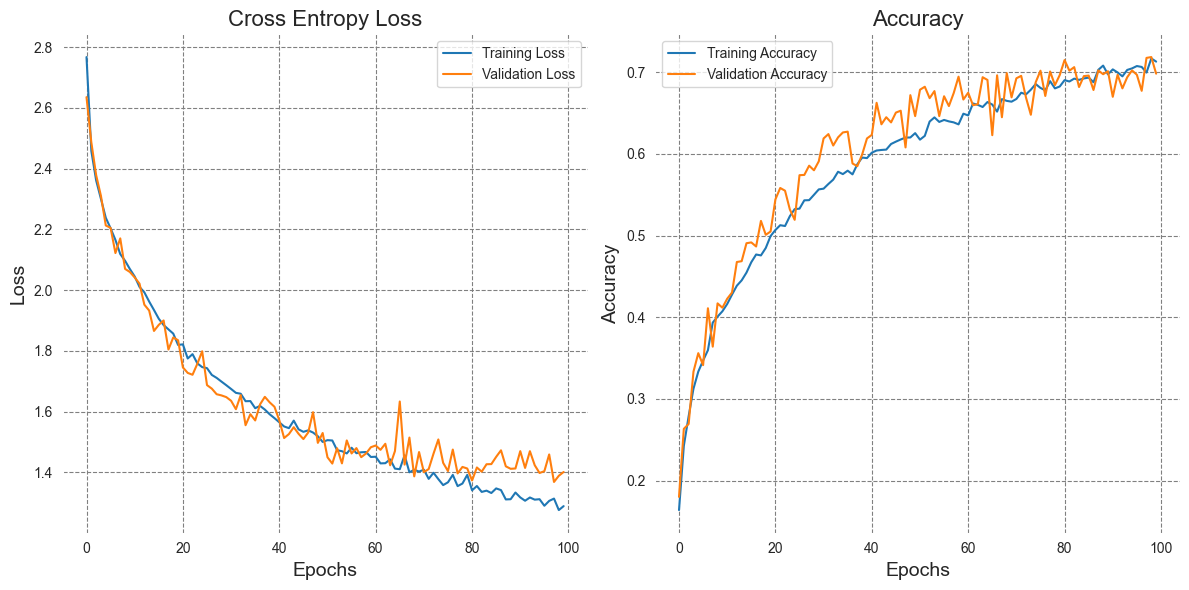

In [41]:
plot_lc(history)

In [39]:
from tensorflow.keras.models import load_model
model = load_model("l2Model31.h5")
# Evaluate the model on your test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the loss and accuracy
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

94/94 [==============================] - 1s 4ms/step - loss: 1.3666 - accuracy: 0.7397
Test Loss: 1.3666342496871948
Test Accuracy: 0.7396666407585144


In [27]:
model = Sequential()

num_classes = 15

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Dont use data augmentation(datagen.flow)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])
model.summary()
model.save("doubleConvModel31.h5")

Epoch 1/100
283/283 [==============================] - 34s 114ms/step - loss: 2.3510 - accuracy: 0.2240 - val_loss: 2.0630 - val_accuracy: 0.3383
Epoch 2/100
283/283 [==============================] - 29s 101ms/step - loss: 1.8505 - accuracy: 0.4116 - val_loss: 1.6952 - val_accuracy: 0.4600
Epoch 3/100
283/283 [==============================] - 28s 100ms/step - loss: 1.5682 - accuracy: 0.4916 - val_loss: 1.5550 - val_accuracy: 0.4817
Epoch 4/100
283/283 [==============================] - 30s 107ms/step - loss: 1.3951 - accuracy: 0.5525 - val_loss: 1.3240 - val_accuracy: 0.5713
Epoch 5/100
283/283 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.6033

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 32s 113ms/step - loss: 1.2354 - accuracy: 0.6033 - val_loss: 1.1451 - val_accuracy: 0.6347
Epoch 6/100
283/283 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.6381

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 28s 100ms/step - loss: 1.1124 - accuracy: 0.6381 - val_loss: 1.0716 - val_accuracy: 0.6560
Epoch 7/100
283/283 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6737

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 32s 112ms/step - loss: 0.9986 - accuracy: 0.6737 - val_loss: 0.9723 - val_accuracy: 0.6910
Epoch 8/100
283/283 [==============================] - ETA: 0s - loss: 0.9147 - accuracy: 0.7043

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 32s 113ms/step - loss: 0.9147 - accuracy: 0.7043 - val_loss: 0.9625 - val_accuracy: 0.6917
Epoch 9/100
283/283 [==============================] - ETA: 0s - loss: 0.8300 - accuracy: 0.7288

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 32s 115ms/step - loss: 0.8300 - accuracy: 0.7288 - val_loss: 0.9138 - val_accuracy: 0.7183
Epoch 10/100
282/283 [============================>.] - ETA: 0s - loss: 0.7733 - accuracy: 0.7492

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 29s 101ms/step - loss: 0.7733 - accuracy: 0.7492 - val_loss: 0.7980 - val_accuracy: 0.7583
Epoch 11/100
283/283 [==============================] - 30s 105ms/step - loss: 0.7231 - accuracy: 0.7669 - val_loss: 0.8167 - val_accuracy: 0.7473
Epoch 12/100
283/283 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.7869

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 30s 107ms/step - loss: 0.6659 - accuracy: 0.7869 - val_loss: 0.7926 - val_accuracy: 0.7647
Epoch 13/100
283/283 [==============================] - 26s 93ms/step - loss: 0.6299 - accuracy: 0.7923 - val_loss: 0.7972 - val_accuracy: 0.7497
Epoch 14/100
282/283 [============================>.] - ETA: 0s - loss: 0.5705 - accuracy: 0.8090

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 31s 108ms/step - loss: 0.5705 - accuracy: 0.8089 - val_loss: 0.7560 - val_accuracy: 0.7800
Epoch 15/100
282/283 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.8153

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 31s 108ms/step - loss: 0.5595 - accuracy: 0.8150 - val_loss: 0.7251 - val_accuracy: 0.7780
Epoch 16/100
283/283 [==============================] - 25s 89ms/step - loss: 0.5248 - accuracy: 0.8251 - val_loss: 0.7923 - val_accuracy: 0.7547
Epoch 17/100
283/283 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8425

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 31s 109ms/step - loss: 0.4794 - accuracy: 0.8425 - val_loss: 0.6950 - val_accuracy: 0.7807
Epoch 18/100
283/283 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8466

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 31s 109ms/step - loss: 0.4591 - accuracy: 0.8466 - val_loss: 0.6911 - val_accuracy: 0.7950
Epoch 19/100
282/283 [============================>.] - ETA: 0s - loss: 0.4256 - accuracy: 0.8556

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 31s 110ms/step - loss: 0.4255 - accuracy: 0.8557 - val_loss: 0.6658 - val_accuracy: 0.8027
Epoch 20/100
283/283 [==============================] - 21s 75ms/step - loss: 0.4081 - accuracy: 0.8588 - val_loss: 0.6802 - val_accuracy: 0.8003
Epoch 21/100
283/283 [==============================] - 30s 105ms/step - loss: 0.4114 - accuracy: 0.8600 - val_loss: 0.6746 - val_accuracy: 0.8120
Epoch 22/100
283/283 [==============================] - 29s 103ms/step - loss: 0.3885 - accuracy: 0.8671 - val_loss: 0.6673 - val_accuracy: 0.8113
Epoch 23/100
282/283 [============================>.] - ETA: 0s - loss: 0.3378 - accuracy: 0.8881

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.1s


283/283 [==============================] - 28s 98ms/step - loss: 0.3377 - accuracy: 0.8881 - val_loss: 0.6636 - val_accuracy: 0.8163
Epoch 24/100
283/283 [==============================] - 29s 103ms/step - loss: 0.3329 - accuracy: 0.8872 - val_loss: 0.6942 - val_accuracy: 0.8167
Epoch 25/100
283/283 [==============================] - 29s 102ms/step - loss: 0.3149 - accuracy: 0.8950 - val_loss: 0.8550 - val_accuracy: 0.7650
Epoch 26/100
283/283 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8937

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 28s 99ms/step - loss: 0.3111 - accuracy: 0.8937 - val_loss: 0.6437 - val_accuracy: 0.8237
Epoch 27/100
283/283 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8999

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_190405-trybbtd2\files\model-best)... Done. 0.0s


283/283 [==============================] - 29s 104ms/step - loss: 0.2957 - accuracy: 0.8999 - val_loss: 0.6274 - val_accuracy: 0.8300
Epoch 28/100
283/283 [==============================] - 28s 98ms/step - loss: 0.2841 - accuracy: 0.9027 - val_loss: 0.6690 - val_accuracy: 0.8237
Epoch 29/100
283/283 [==============================] - 20s 69ms/step - loss: 0.2616 - accuracy: 0.9109 - val_loss: 0.6855 - val_accuracy: 0.8190
Epoch 30/100
283/283 [==============================] - 23s 82ms/step - loss: 0.2480 - accuracy: 0.9134 - val_loss: 0.6696 - val_accuracy: 0.8260
Epoch 31/100
283/283 [==============================] - 28s 99ms/step - loss: 0.2431 - accuracy: 0.9181 - val_loss: 0.6529 - val_accuracy: 0.8287
Epoch 32/100
283/283 [==============================] - 27s 95ms/step - loss: 0.2333 - accuracy: 0.9212 - val_loss: 0.6752 - val_accuracy: 0.8320
Epoch 33/100
283/283 [==============================] - 26s 91ms/step - loss: 0.2314 - accuracy: 0.9184 - val_loss: 0.6670 - val_accurac

In [42]:
from tensorflow.keras.regularizers import l2
model = Sequential()

num_classes = 15

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, kernel_regularizer = l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Dont use data augmentation(datagen.flow)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])
model.summary()
model.save_weights("finalModel31Weights.h5")
model.save("finalModel31.h5")

Epoch 1/100
  6/283 [..............................] - ETA: 16s - loss: 4.7930 - accuracy: 0.1510WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0379s). Check your callbacks.


283/283 [==============================] - 18s 60ms/step - loss: 2.7089 - accuracy: 0.1931 - val_loss: 2.4455 - val_accuracy: 0.2250
Epoch 2/100
283/283 [==============================] - 16s 57ms/step - loss: 2.1665 - accuracy: 0.3449 - val_loss: 2.0693 - val_accuracy: 0.3880
Epoch 3/100
283/283 [==============================] - 15s 54ms/step - loss: 2.0031 - accuracy: 0.4036 - val_loss: 1.9356 - val_accuracy: 0.4287
Epoch 4/100
283/283 [==============================] - 14s 51ms/step - loss: 1.8820 - accuracy: 0.4509 - val_loss: 1.7696 - val_accuracy: 0.4913
Epoch 5/100
283/283 [==============================] - 16s 57ms/step - loss: 1.7786 - accuracy: 0.4829 - val_loss: 1.7261 - val_accuracy: 0.5000
Epoch 6/100
283/283 [==============================] - 14s 50ms/step - loss: 1.6905 - accuracy: 0.5183 - val_loss: 1.6783 - val_accuracy: 0.5100
Epoch 7/100
283/283 [==============================] - 21s 73ms/step - loss: 1.6136 - accuracy: 0.5496 - val_loss: 1.5722 - val_accuracy: 0.55

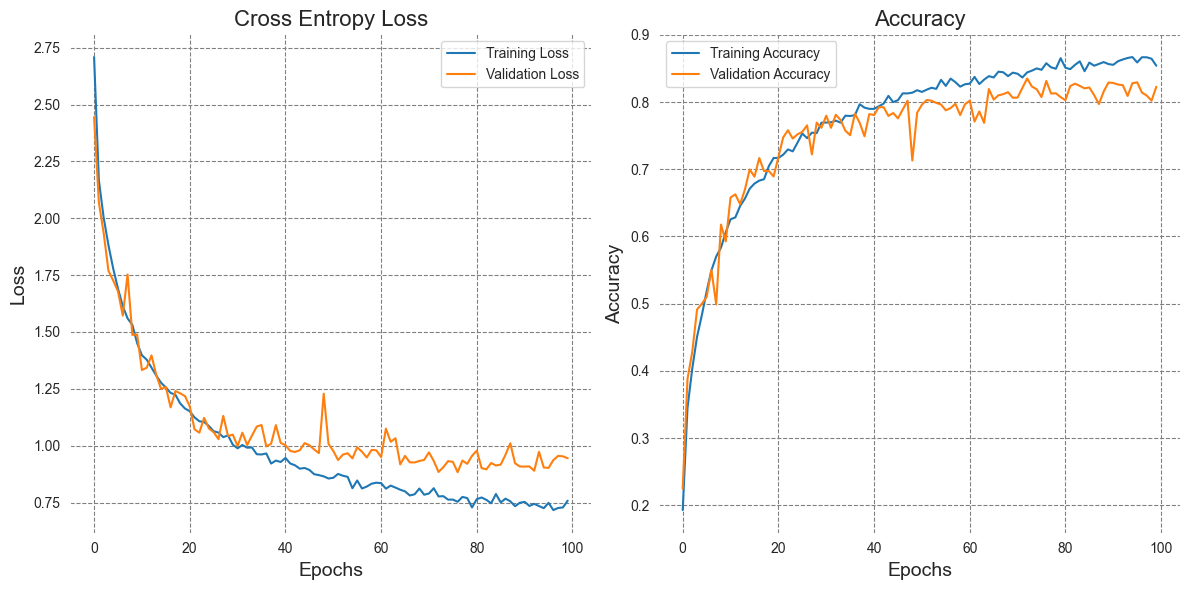

In [43]:
plot_lc(history)

In [44]:
print_training_history(history)

Training Loss: 0.7580636143684387
Validation Loss: 0.9446138739585876
Training Accuracy: 0.854009747505188
Validation Accuracy: 0.8226666450500488


<hr>

### References:
https://arxiv.org/pdf/2102.01582.pdf